In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arhamrumi/amazon-product-reviews")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arhamrumi/amazon-product-reviews/versions/1


In [ ]:
import pandas as pd

data = pd.read_csv(path+"/Reviews.csv")

In [ ]:
data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [ ]:
data['ProfileName'].fillna(value = 'User', inplace = True)

<ipython-input-5-4622189cea04>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ProfileName'].fillna(value = 'User', inplace = True)


In [ ]:
data['Summary'].fillna(value="Average",inplace=True)

<ipython-input-6-e262b6165a05>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Summary'].fillna(value="Average",inplace=True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
import spacy
import re
from tqdm import tqdm  # For progress bar

# Load spaCy model (ensure it's GPU-enabled)
nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])

# Function to clean text (no need for NLTK stopwords anymore)
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = text.lower()

    # Tokenize and remove stop words using spaCy's stopwords
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    doc = nlp(text)
    cleaned_text = ' '.join([token.lemma_ for token in doc if token.text not in stop_words])

    return cleaned_text

# Batch processing with spaCy's nlp.pipe()
def batch_process_texts(texts, batch_size=1000):
    # Use nlp.pipe for batch processing (it's much faster)
    cleaned_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=4)):  # `n_process=4` for parallelism
        cleaned_text = ' '.join([token.lemma_ for token in doc if token.text not in spacy.lang.en.stop_words.STOP_WORDS])
        cleaned_texts.append(cleaned_text)
    return cleaned_texts

# Process the 'Text' column in batches
data['Cleaned_Text'] = batch_process_texts(data['Text'].tolist(), batch_size=500)


568454it [18:04, 524.24it/s] 


In [ ]:
import gensim
from gensim import corpora
import spacy
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# Use spaCy's lemmatizer (disable parser and ner to save time)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Tokenize and preprocess the text
def preprocess_for_lda(text):
    # Tokenize and lemmatize, removing stopwords
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.text not in spacy.lang.en.stop_words.STOP_WORDS and token.is_alpha]

# Efficiently process the text using nlp.pipe()
def process_texts_in_batches(texts, batch_size=1000):
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=4):  # Using 4 cores for parallel processing
        processed_texts.append([token.lemma_ for token in doc if token.text not in spacy.lang.en.stop_words.STOP_WORDS and token.is_alpha])
    return processed_texts

# Preprocess all the cleaned text for LDA in batches
batch_size = 5000
processed_texts = process_texts_in_batches(data['Cleaned_Text'].tolist(), batch_size=batch_size)

# Create a dictionary and corpus for LDA
# Using parallel processing for dictionary creation
def create_corpus_and_dictionary(processed_texts):
    dictionary = corpora.Dictionary(processed_texts)
    corpus = [dictionary.doc2bow(text) for text in processed_texts]
    return dictionary, corpus

# Use ProcessPoolExecutor to create the corpus and dictionary in parallel
with ProcessPoolExecutor() as executor:
    future = executor.submit(create_corpus_and_dictionary, processed_texts)
    dictionary, corpus = future.result()

# Train the LDA model with more optimized parameters
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=5, workers=4)

# Display the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.060*"I" + 0.037*"food" + 0.032*"dog" + 0.020*"treat" + 0.019*"cat"')
(1, '0.061*"I" + 0.025*"taste" + 0.020*"like" + 0.015*"flavor" + 0.015*"good"')
(2, '0.086*"I" + 0.044*"coffee" + 0.039*"tea" + 0.020*"cup" + 0.020*"flavor"')
(3, '0.086*"I" + 0.014*"use" + 0.011*"product" + 0.009*"work" + 0.009*"like"')
(4, '0.092*"I" + 0.016*"good" + 0.015*"buy" + 0.013*"order" + 0.013*"product"')


In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Compound score is a good overall sentiment indicator

# Optimized sentiment analysis using multiprocessing (for large datasets)
from concurrent.futures import ProcessPoolExecutor

def process_sentiments(texts):
    return [get_sentiment(text) for text in texts]

# Use ProcessPoolExecutor to apply sentiment analysis in parallel
with ProcessPoolExecutor() as executor:
    # Split the data into chunks for parallel processing
    chunk_size = 10000
    chunked_data = [data['Cleaned_Text'][i:i + chunk_size] for i in range(0, len(data), chunk_size)]

    # Apply the sentiment analysis function in parallel
    results = executor.map(process_sentiments, chunked_data)

# Flatten the results and assign them back to the DataFrame
sentiment_scores = [score for result in results for score in result]
data['Sentiment_Score'] = sentiment_scores

# Categorize sentiment based on the compound score
data['Sentiment_Label'] = data['Sentiment_Score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Display the sentiment distribution
print(data['Sentiment_Label'].value_counts())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment_Label
positive    517041
negative     43633
neutral       7780
Name: count, dtype: int64


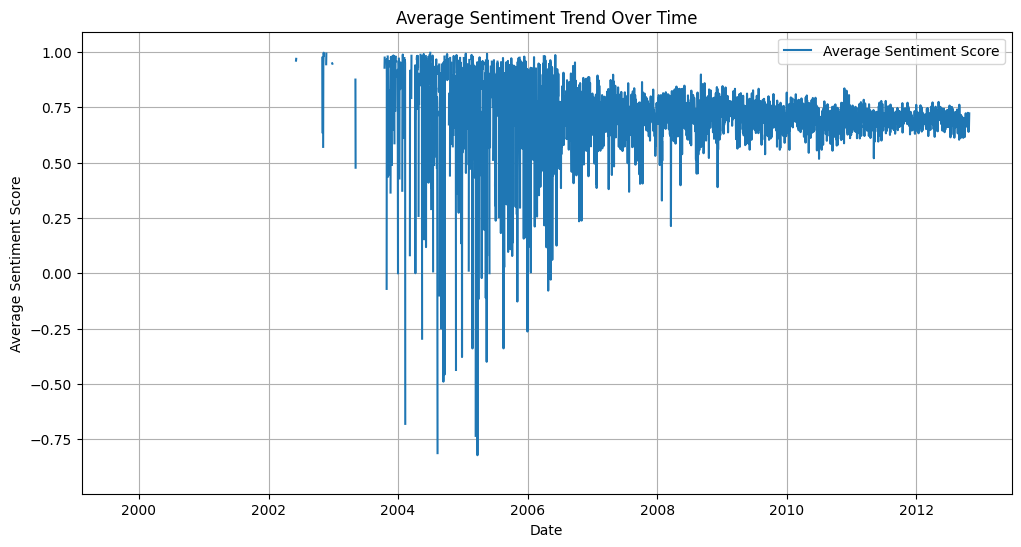

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert 'Time' to a datetime format (assuming it's in UNIX timestamp)
data['Time'] = pd.to_datetime(data['Time'], unit='s')

# Resample by day and calculate the mean sentiment score for each day
daily_sentiment = data.resample('D', on='Time')['Sentiment_Score'].mean()

# Plot the sentiment trend over time
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment.index, daily_sentiment.values, label='Average Sentiment Score')
plt.title('Average Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.legend()
plt.show()


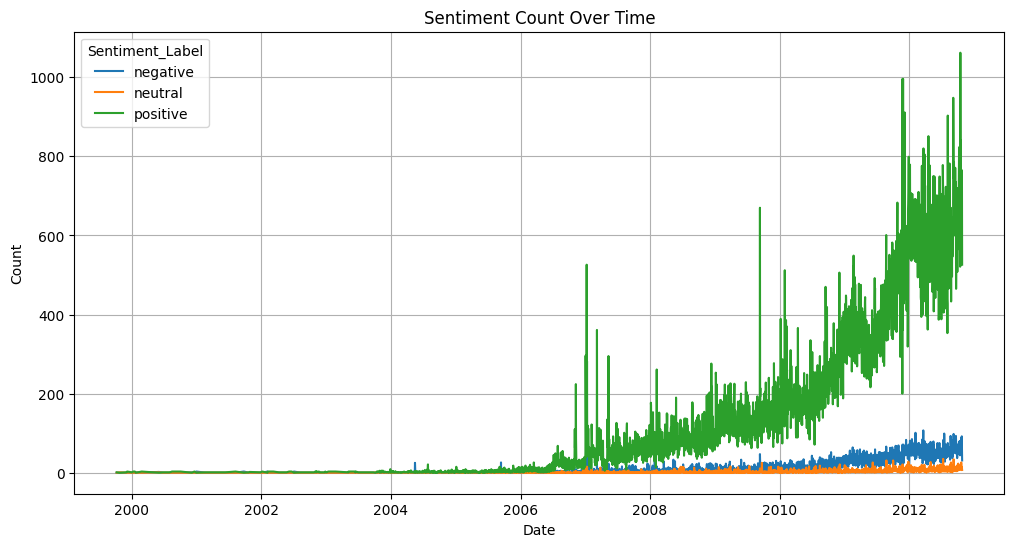

In [ ]:
# Group by date and sentiment label
sentiment_count = data.groupby([data['Time'].dt.date, 'Sentiment_Label']).size().unstack().fillna(0)

# Plot the sentiment count over time
sentiment_count.plot(kind='line', figsize=(12, 6))
plt.title('Sentiment Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [ ]:
!pip install streamlit
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load your data and process it (same as previous steps)
# Assuming data is already preprocessed

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
data['Sentiment_Score'] = data['Cleaned_Text'].apply(lambda x: sia.polarity_scores(x)['compound'])
data['Sentiment_Label'] = data['Sentiment_Score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Title of the app
st.title('Customer Feedback Sentiment Analysis and Topic Modeling')

# Display sentiment analysis distribution
st.subheader('Sentiment Distribution')
sentiment_dist = data['Sentiment_Label'].value_counts()
st.bar_chart(sentiment_dist)

# Sentiment trend over time
st.subheader('Sentiment Trend Over Time')
daily_sentiment = data.resample('D', on='Time')['Sentiment_Score'].mean()
st.line_chart(daily_sentiment)

# Topic modeling output
st.subheader('Top Topics')
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    st.write(topic)

# You can also add interactivity features such as filtering by time or sentiment


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.4 MB/s eta 0:00:00


2025-02-04 14:37:21.221 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 14:37:21.290 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-04 14:37:21.291 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 14:37:21.292 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 14:37:21.293 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 14:37:21.621 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 14:37:21.622 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 14:37:21.623 Thread 'MainThread': mi

In [ ]:
!npx localtunnel --port 8501  & curl ipv4.icanhazip.com

34.42.17.11
⠙your url is: https://tasty-groups-shout.loca.lt
